# TCR metrics

In [1]:
# IMPORTS
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering
from sklearn.decomposition import PCA

from sklearn.metrics import silhouette_score

from adjustText import adjust_text



## Import data

In [2]:
# Patient list ID
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK017', 'SARK021', 'SARK025', 
            'SARK041', 'SARK011', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']
# pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK021', 'SARK025', 
            # 'SARK041', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK059']

# Read dataset
file_path = 'TCR_seq_new.xlsx' 

# Dictionaries with all the sequences
all_counts = {}
all_freq = {}

# Dictionaries restricted to the top 100 sequences
all_counts_100 = {}
all_original_freq_100 = {}  # Original frequencies
all_recalc_freq_100 = {}  # Frequencies calculated over the 100 top ranked sequences

# Load the Excel file for each patient
for i, pat in enumerate(pat_list):
        # Read excel sheet (equivalent to 1 patient)
        sheet_index = 2*i
        counts_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')
        freq_df = pd.read_excel(file_path, sheet_name=sheet_index+1, engine='openpyxl')

        # Remove rows where 'CDR3.amino.acid.sequence' is NaN
        counts_df = counts_df.dropna(subset=['CDR3.amino.acid.sequence'])
        freq_df = freq_df.dropna(subset=['CDR3.amino.acid.sequence'])

        # Select columns containing 'Day' (time points)
        counts_df = counts_df.filter(regex='Day').copy()
        freq_df = freq_df.filter(regex='Day').copy()

        # Convert all values to numeric (important for summing later)
        counts_df = counts_df.apply(pd.to_numeric, errors='coerce')
        freq_df = freq_df.apply(pd.to_numeric, errors='coerce')

        # Replace missing values with a 0 if the freq data has a 0
        counts_df = counts_df.where(~(counts_df.isna()), 0)
        freq_df = freq_df.where(~(freq_df.isna()), 0)

        # Rename columns by extracting the numeric part and converting to integer
        counts_df.columns = [int(col.split(' ')[1]) for col in counts_df.columns]
        freq_df.columns = [int(col.split(' ')[1]) for col in freq_df.columns]

        # Ensure numbers are in float type
        counts_df = counts_df.astype(float)
        freq_df = freq_df.astype(float)

        counts_df["Total"] = counts_df.sum(axis=1)
        freq_df["Total"] = freq_df.sum(axis=1)

        # Add an ID column - To later be able to identify the sequences if necessary
        counts_df['id'] = ['TCR_' + str(j + 1) for j in range(len(counts_df))]
        freq_df['id'] = ['TCR_' + str(j + 1) for j in range(len(freq_df))]

        # Sort by counts of 'Day 0' cols
        counts_df = counts_df.sort_values(by=counts_df.columns[0], ascending=False, kind="mergesort").reset_index(drop=True)
        freq_df = freq_df.sort_values(by=freq_df.columns[0], ascending=False, kind="mergesort").reset_index(drop=True)

        
        # Melt the dataframe for plotting (id, time, counts)
        counts_m = counts_df.drop(columns=["Total"]).melt(id_vars='id', var_name='time', value_name='counts').copy()
        freq_m = freq_df.drop(columns=["Total"]).melt(id_vars='id', var_name='time', value_name='counts').copy()
       
        # Store in dictionary
        all_counts[pat] = counts_m
        all_freq[pat] = freq_m


In [3]:
# Exclude excluded patients
excluded_patients = ["SARK017", "SARK011", "SARK052"]
all_freq = {pat: df for pat, df in all_freq.items() if pat not in excluded_patients}
all_counts = {pat: df for pat, df in all_counts.items() if pat not in excluded_patients}

## Metrics definition

### One time metrics

In [4]:
from scipy.stats import entropy
def adapted_gini_normalized(freqs):
    """
    Compute the normalized Adapted Gini coefficient (AG) from Rousseau et al. (1999).
    Input:
        freqs: array-like, clone frequencies (not necessarily normalized)
    Returns:
        Normalized AG value in [0, 1]
    """
    freqs = np.array(freqs)
    freqs = freqs[freqs > 0]  # remove zeros
    norm_freqs = freqs / freqs.sum()
    sorted_desc = np.sort(norm_freqs)[::-1]  # sort descending
    S = len(sorted_desc)
    ag_raw = 2 * np.sum((np.arange(1, S + 1)) * sorted_desc) - 1
    ag_normalized = (2 / np.pi) * np.arctan(ag_raw)
    return ag_normalized

def compute_tcr_metrics(freq_df):
    results = []

    for time in sorted(freq_df['time'].unique()):
        df_time = freq_df[freq_df['time'] == time]
        freqs = df_time['counts'].values
        freqs = freqs[freqs > 0]
        total = freqs.sum()

        if total == 0:
            continue  # skip empty timepoints

         # --- Normalization check ---
        total = freqs.sum()
        if not np.isclose(total, 1.0, atol=1e-3):
            norm_freqs = freqs / total
            print('Freqs not normalised. Normalizing now...')
        else:
            norm_freqs = freqs

        richness = len(freqs)

        # Shannon entropy
        shannon_entropy = entropy(norm_freqs, base=2)

        # Pielou's index (normalized entropy)
        pielou_index = shannon_entropy / np.log2(richness) if richness > 1 else 0

        # Clonality = 1 - Pielou
        clonality = 1 - pielou_index if richness > 1 else 0

        # Inverse Simpson index
        inv_simpson = 1 / np.sum(norm_freqs ** 2)

        # Gini–Simpson index (1 - Simpson's dominance index)
        gini_simpson_index = 1 - np.sum(norm_freqs ** 2)

        # Adapted Gini coefficient
        gini_coefficient = adapted_gini_normalized(norm_freqs)

        # DE50: number of top clones that make up 50% of frequency
        cum_freqs = np.cumsum(np.sort(norm_freqs)[::-1])
        try:
            de50 = np.argmax(cum_freqs >= 0.5) + 1
        except:
            de50 = np.nan

        results.append({
            'time': time,
            'richness': richness,
            'shannon_entropy': shannon_entropy,
            'pielou_index': pielou_index,
            'clonality': clonality,
            'inverse_simpson': inv_simpson,
            'gini_simpson_index': gini_simpson_index,
            'gini_coefficient': gini_coefficient,
            'DE50': de50
        })

    return pd.DataFrame(results)


### Two set somparison metrics
Implemented but with no intent to use them as of now

In [5]:
def compute_similarity_indices(freq_df):
    timepoints = sorted(freq_df['time'].unique())
    similarities = []

    for i in range(len(timepoints) - 1):
        t1, t2 = timepoints[i], timepoints[i + 1]

        # Set index as TCR ID and get counts for each time point
        df1 = freq_df[freq_df['time'] == t1].set_index('id')['counts']
        df2 = freq_df[freq_df['time'] == t2].set_index('id')['counts']

        # Union of all TCR IDs between the two time points
        all_ids = df1.index.union(df2.index)
        v1 = df1.reindex(all_ids, fill_value=0)
        v2 = df2.reindex(all_ids, fill_value=0)

        # ---------- Jaccard Index ----------
        present1 = v1 > 0
        present2 = v2 > 0
        union = present1 | present2
        intersection = present1 & present2
        jaccard = intersection.sum() / union.sum() if union.sum() > 0 else 0

        # ---------- Morisita–Horn Index ----------
        sum1 = v1.sum()
        sum2 = v2.sum()

        # Convert to relative frequencies
        if sum1 == 0 or sum2 == 0:
            morisita_horn = 0
        else:
            p1 = v1 / sum1
            p2 = v2 / sum2
            numerator = 2 * np.sum(p1 * p2)
            denominator = np.sum(p1**2) + np.sum(p2**2)
            morisita_horn = numerator / denominator if denominator > 0 else 0

        similarities.append({
            'time1': t1,
            'time2': t2,
            'jaccard_index': jaccard,
            'morisita_horn_index': morisita_horn
        })

    return pd.DataFrame(similarities)


### Plotting functions

In [6]:
# Function to plot a chosen metric over time for all patients
def plot_metric_over_time(all_metrics, metric_name):
    plt.figure(figsize=(12, 6))
    
    # Get a "tab20" colormap with as many distinct colors as there are patients
    # (If you have >20 patients, it will still work but eventually reuse colors)
    cmap = plt.cm.get_cmap('tab20', len(all_metrics))

    for i, (pat, df) in enumerate(all_metrics.items()):
        df_sorted = df.sort_values(by='time')
        # Pick a unique color from the palette
        color = cmap(i)
        plt.plot(
            df_sorted['time'], 
            df_sorted[metric_name], 
            marker='o', 
            label=pat,
            color=color
        )

    plt.xlabel('Time')
    plt.ylabel(metric_name.replace('_', ' ').title())
    plt.title(f'{metric_name.replace("_", " ").title()} Over Time')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    

### Other helper functions

In [7]:
# Function to combine metrics from all patients into one DataFrame
def combine_all_metrics(all_metrics):
    combined = []
    for pat, df in all_metrics.items():
        df = df.copy()
        df['patient'] = pat
        combined.append(df)
    return pd.concat(combined, ignore_index=True)

# Function to combine similarity indices from all patients into one DataFrame
def combine_all_similarities(all_freq):
    combined_sim = []
    for pat, freq_df in all_freq.items():
        sim_df = compute_similarity_indices(freq_df)
        sim_df['patient'] = pat
        combined_sim.append(sim_df)
    return pd.concat(combined_sim, ignore_index=True)

## Metric calculation

In [ ]:
# Use all sequences (not just top 100) for metrics
all_metrics = {pat: compute_tcr_metrics(freq_df) for pat, freq_df in all_freq.items()}

# Combine metrics into a single DataFrame for further analysis or export
combined_metrics_df = combine_all_metrics(all_metrics)

# Compute similarity indices between consecutive timepoints for each patient
# all_similarities_df = combine_all_similarities(all_freq)

## Plots

C:\Users\viola\AppData\Local\Temp\ipykernel_28816\720791364.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('tab20', len(all_metrics))


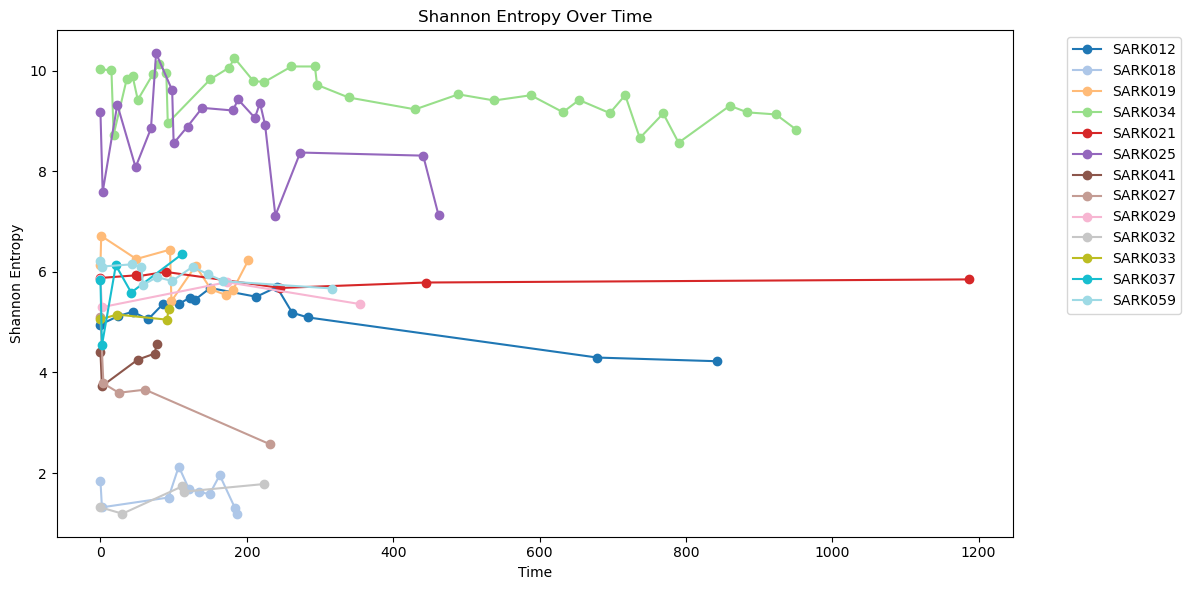

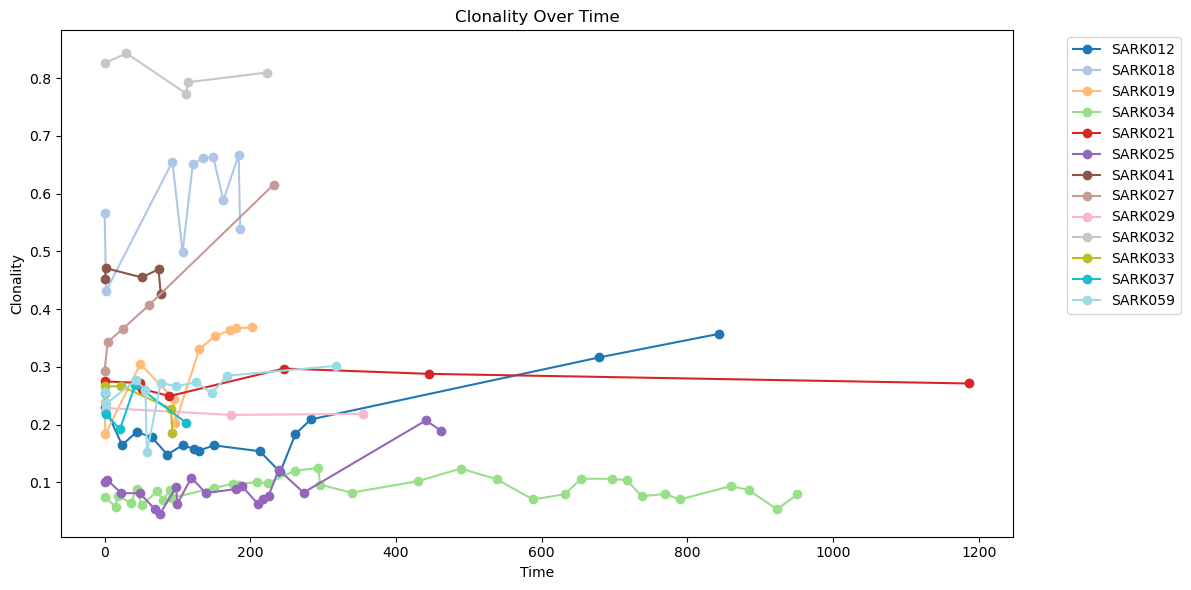

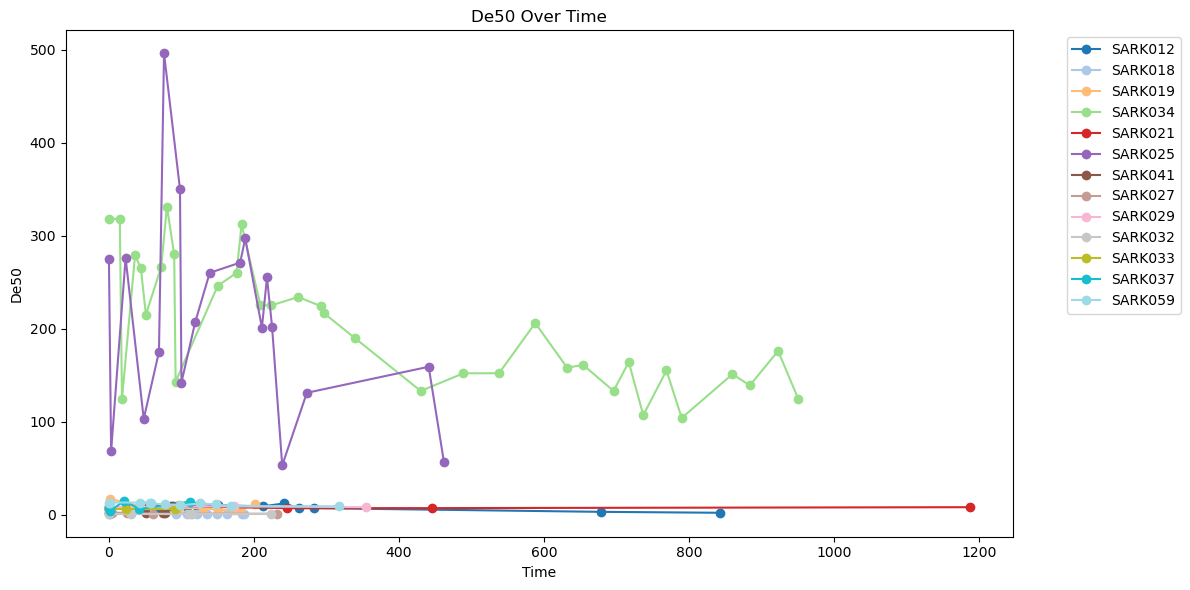

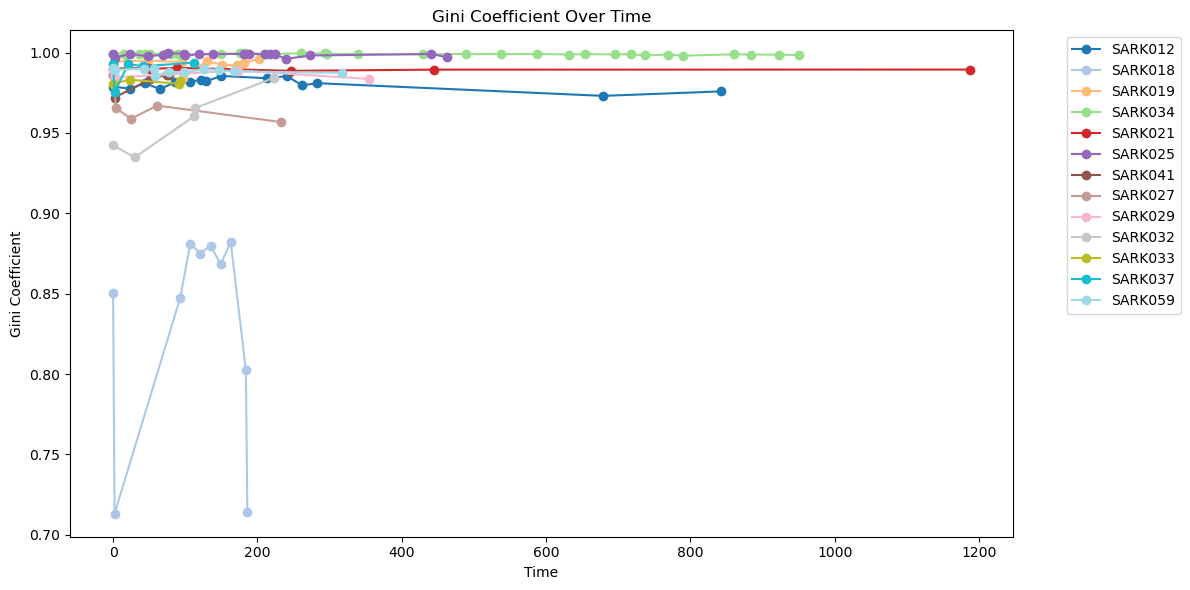

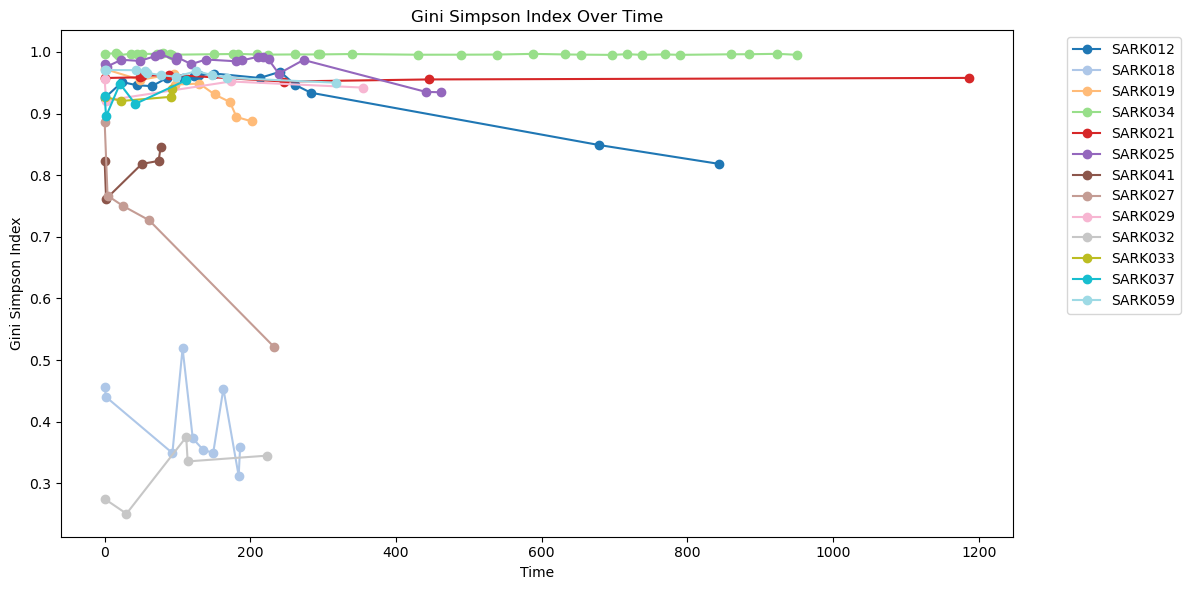

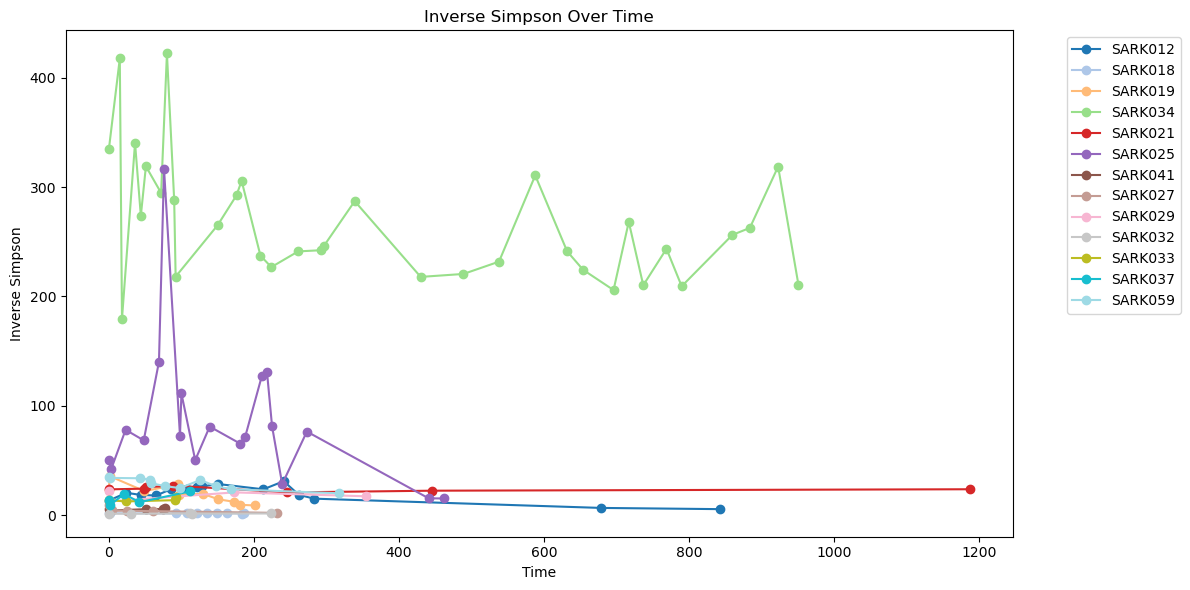

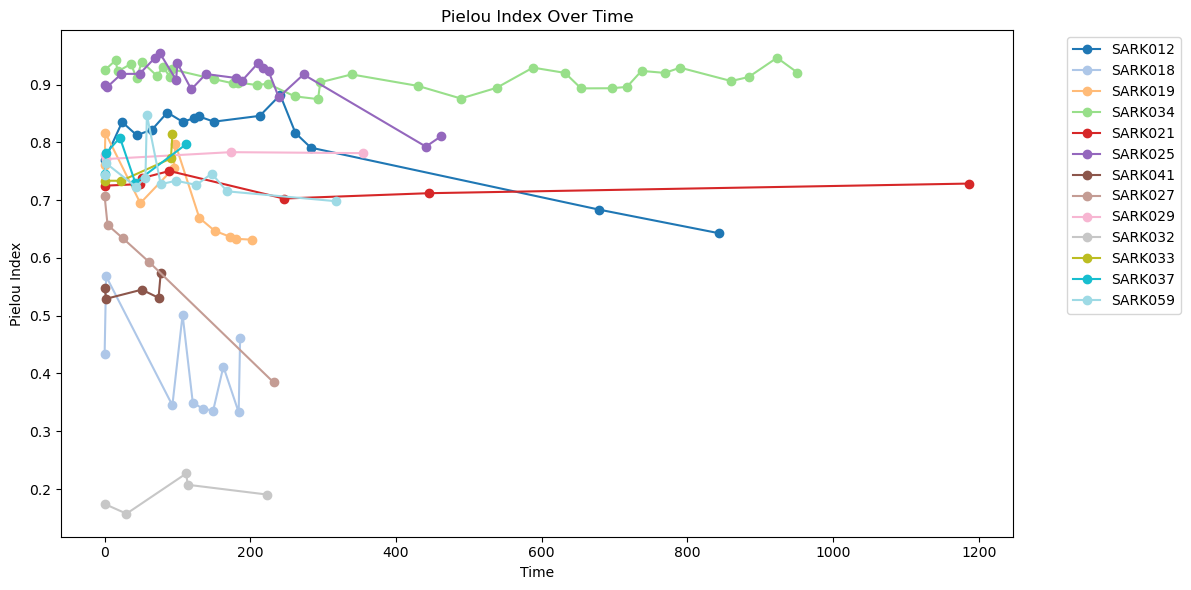

Combined Metrics Across Patients:
   time  richness  shannon_entropy  pielou_index  clonality  inverse_simpson  \
0     0        87         4.952647      0.768693   0.231307        13.362247   
1    24        70         5.119298      0.835220   0.164780        20.450145   
2    44        85         5.207479      0.812476   0.187524        18.497937   
3    65        71         5.054850      0.821961   0.178039        17.982193   
4    86        79         5.369021      0.851714   0.148286        23.828550   

   gini_simpson_index  gini_coefficient  DE50  patient  
0            0.925162          0.978761     6  SARK012  
1            0.951101          0.977513     7  SARK012  
2            0.945940          0.980905     7  SARK012  
3            0.944389          0.977273     7  SARK012  
4            0.958034          0.981588     9  SARK012  

Similarity Indices Across Patients:
   time1  time2  jaccard_index  morisita_horn_index  patient
0      0     24       0.256000             0.

In [ ]:
plot_metric_over_time(all_metrics, 'shannon_entropy')
plot_metric_over_time(all_metrics, 'clonality')
plot_metric_over_time(all_metrics, 'DE50')
plot_metric_over_time(all_metrics, 'gini_coefficient')
plot_metric_over_time(all_metrics, 'gini_simpson_index')
plot_metric_over_time(all_metrics, 'inverse_simpson')
plot_metric_over_time(all_metrics, 'pielou_index')

# Inspect the combined metrics and similarities:
print("Combined Metrics Across Patients:")
print(combined_metrics_df.head())

# print("\nSimilarity Indices Across Patients:")
# print(all_similarities_df.head())

## Before/After comparison

In [ ]:
def compare_first_last(metrics_df):
    # Group by patient
    grouped = metrics_df.groupby('patient')

    comparisons = []

    for patient, df in grouped:
        df_sorted = df.sort_values('time')
        first = df_sorted.iloc[0]
        last = df_sorted.iloc[-1]

        comparisons.append({
            'patient': patient,
            'time_first': first['time'],
            'time_last': last['time'],
            # 'richness_first': first['richness'],
            # 'richness_last': last['richness'],
            # 'richness_diff': last['richness'] - first['richness'],

            'shannon_entropy_first': first['shannon_entropy'],
            'shannon_entropy_last': last['shannon_entropy'],
            'shannon_entropy_diff': last['shannon_entropy'] - first['shannon_entropy'],

            'clonality_first': first['clonality'],
            'clonality_last': last['clonality'],
            'clonality_diff': last['clonality'] - first['clonality'],

            'DE50_first': first['DE50'],
            'DE50_last': last['DE50'],
            'DE50_diff': last['DE50'] - first['DE50'],

            'gini_coefficient_first': first['gini_coefficient'],
            'gini_coefficient_last': last['gini_coefficient'],
            'gini_coefficient_diff': last['gini_coefficient'] - first['gini_coefficient'],

            'gini_simpson_index_first': first['gini_simpson_index'],
            'gini_simpson_index_last': last['gini_simpson_index'],
            'gini_simpson_index_diff': last['gini_simpson_index'] - first['gini_simpson_index'],

            'inverse_simpson_first': first['inverse_simpson'],
            'inverse_simpson_last': last['inverse_simpson'],
            'inverse_simpson_diff': last['inverse_simpson'] - first['inverse_simpson'],

            'pielou_index_first': first['pielou_index'],
            'pielou_index_last': last['pielou_index'],
            'pielou_index_diff': last['pielou_index'] - first['pielou_index'],
        })

    return pd.DataFrame(comparisons)


In [29]:
comparison_df = compare_first_last(combined_metrics_df)


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_difference_bar(df, metric, label):
    # Ensure values are numeric
    df = df.copy()
    df[metric] = pd.to_numeric(df[metric], errors='coerce')

    # Create color label column
    df['sign'] = df[metric].apply(lambda x: 'Increase' if x >= 0 else 'Decrease')

    # Define color palette
    palette = {
        'Increase': 'deepskyblue',
        'Decrease': 'red'
    }

    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(data=df, x='patient', y=metric, hue='sign', dodge=False, palette=palette)

    plt.axhline(0, color='gray', linestyle='--')
    plt.ylabel(f"Δ {label} (Last - First)", fontsize=13)
    # plt.title(f"Change in {label} from First to Last Timepoint", fontsize=15)
    plt.xticks(rotation=45, fontsize=11)
    plt.legend(title="Change", fontsize=11, title_fontsize=12)
    plt.tight_layout()
    plt.show()


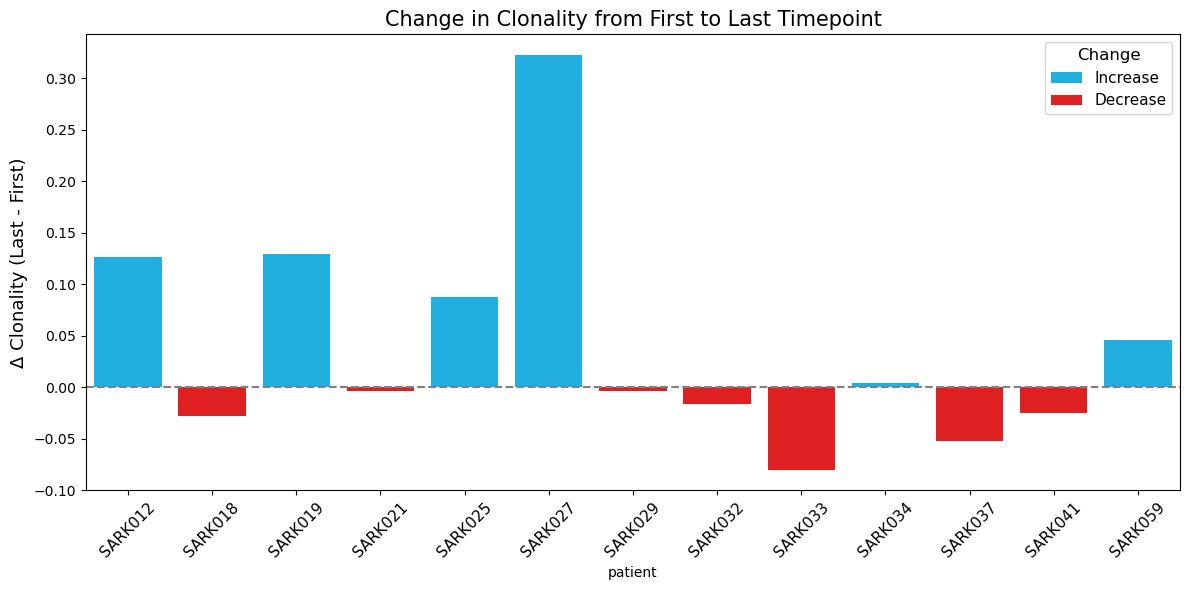

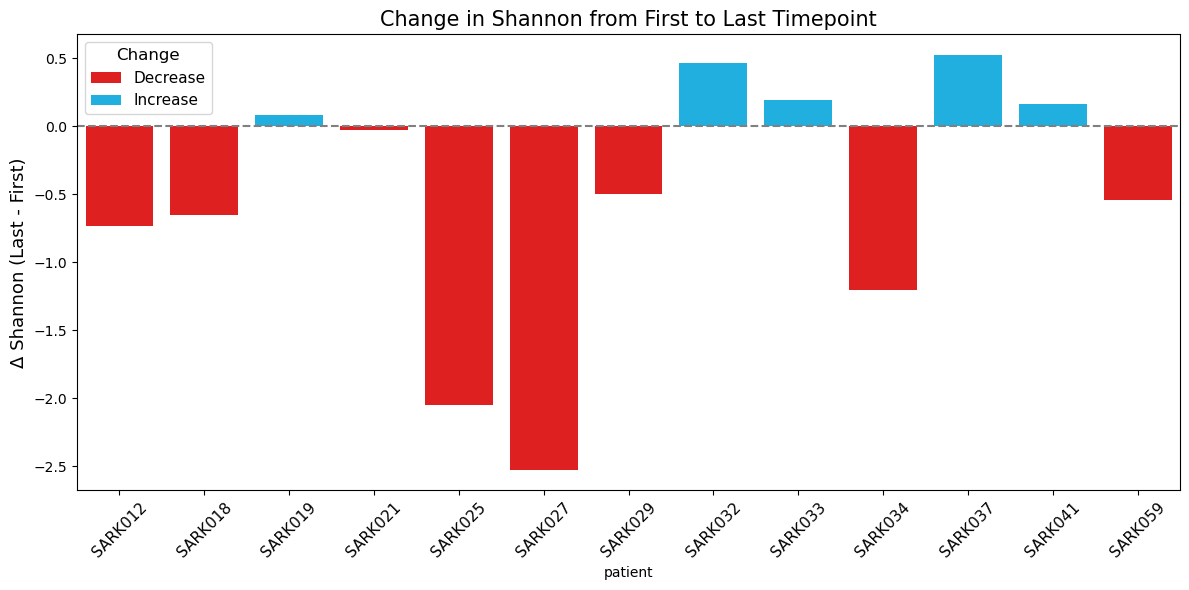

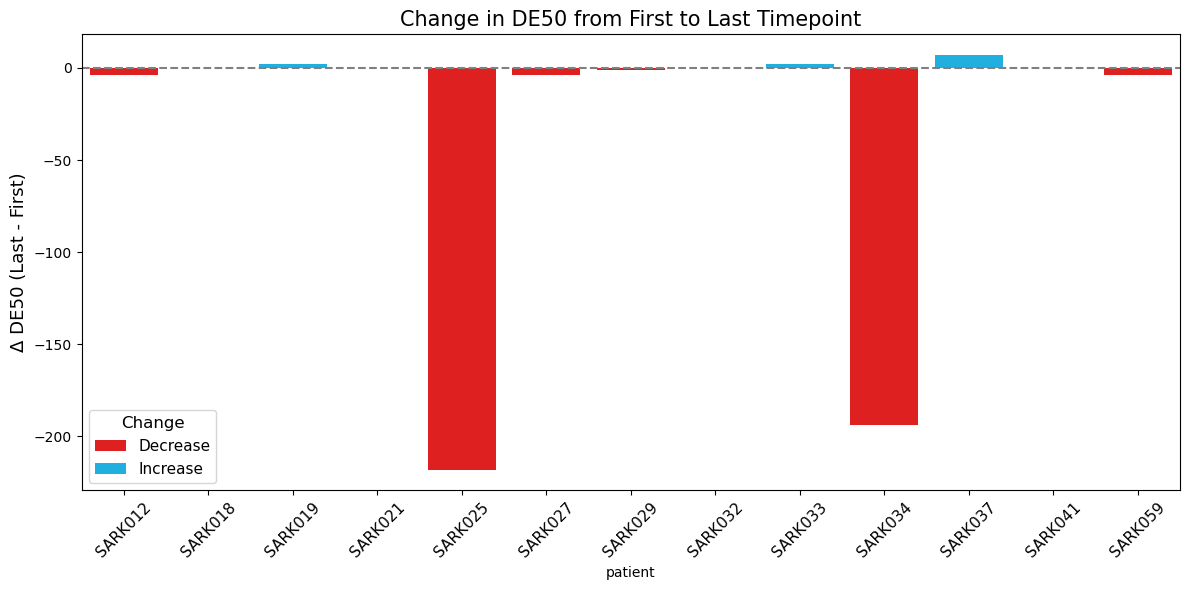

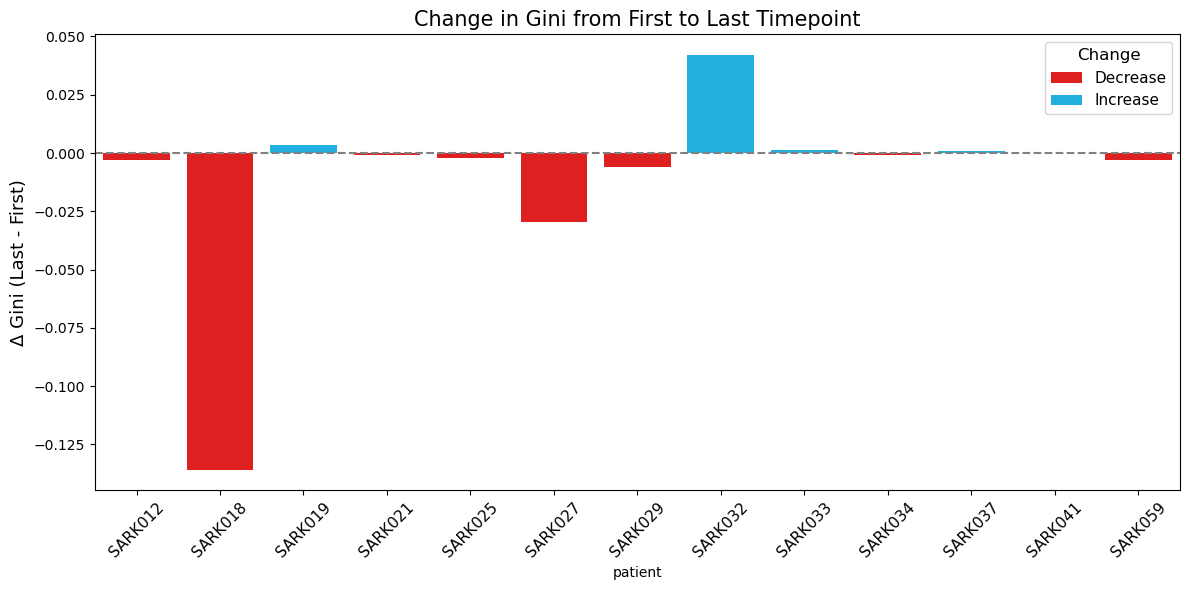

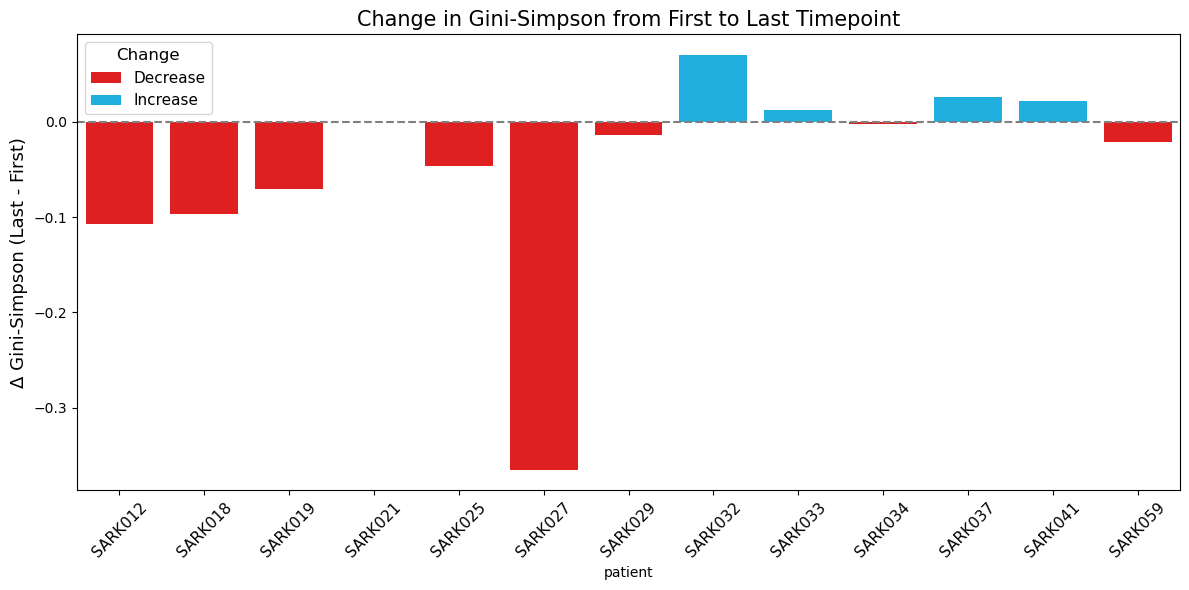

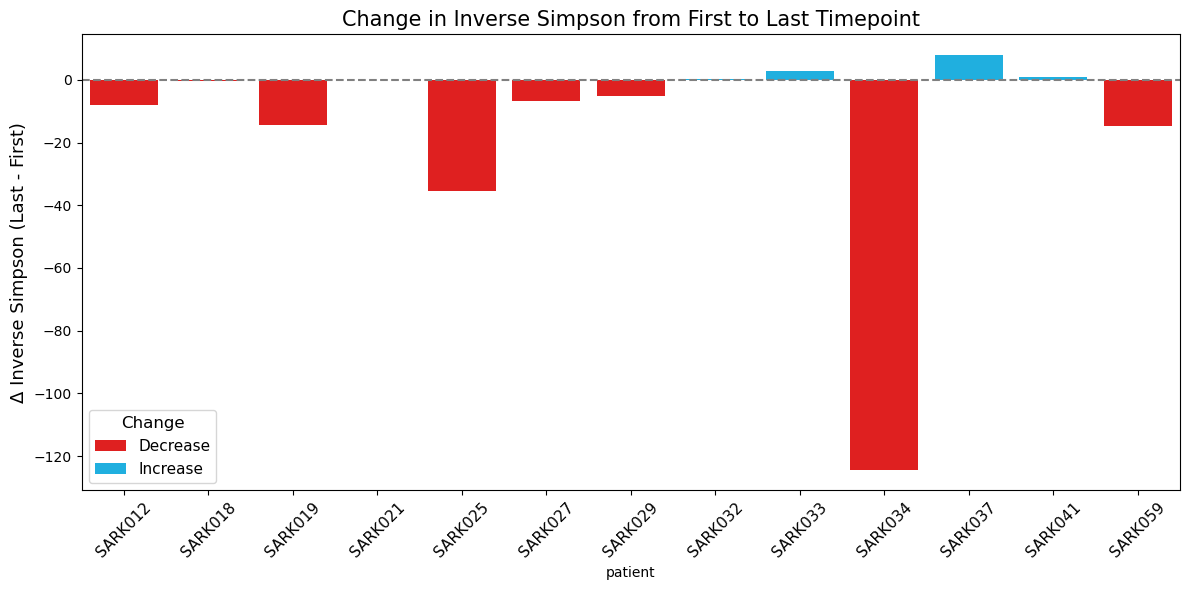

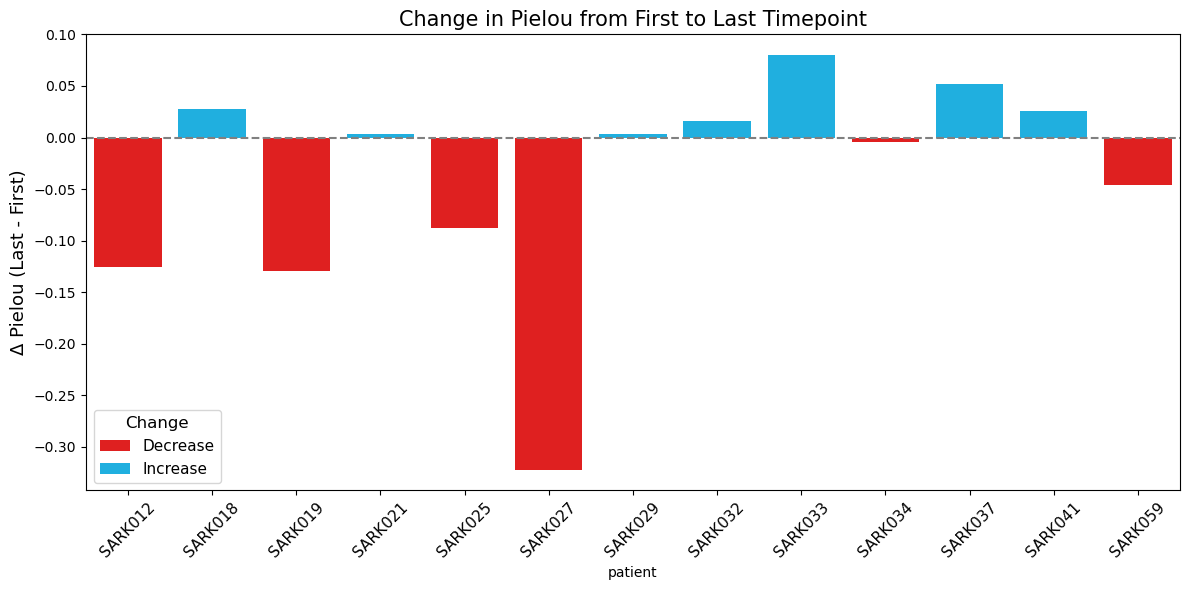

In [36]:
plot_difference_bar(comparison_df,'clonality_diff','Clonality')
plot_difference_bar(comparison_df,'shannon_entropy_diff','Shannon')
plot_difference_bar(comparison_df,'DE50_diff', 'DE50')
plot_difference_bar(comparison_df,'gini_coefficient_diff','Gini')
plot_difference_bar(comparison_df,'gini_simpson_index_diff' ,'Gini-Simpson')
plot_difference_bar(comparison_df,'inverse_simpson_diff','Inverse Simpson')
plot_difference_bar(comparison_df,'pielou_index_diff','Pielou')



# Clustering

## 1st attempt (K means + PCA)

c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


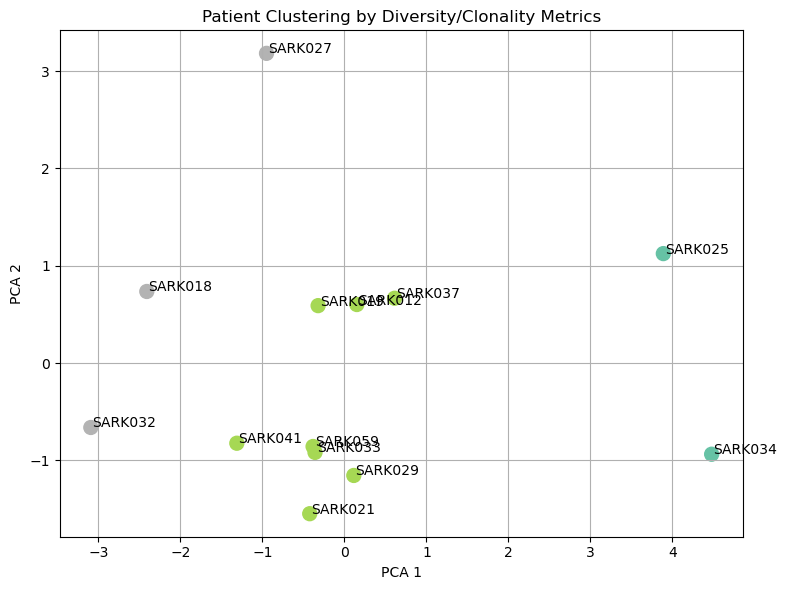

In [ ]:
# Step 1: Get summary metrics per patient
summary_df = combined_metrics_df.groupby("patient").agg({
    "shannon_entropy": ["mean", "std"],
    "clonality": ["mean", "std"],
    "inverse_simpson": ["mean"],
    "gini_coefficient": ["mean"],
    "DE50": ["mean"]
})
summary_df.columns = ["_".join(col) for col in summary_df.columns]
summary_df = summary_df.dropna()  # optional

# Step 2: Normalize
scaled = StandardScaler().fit_transform(summary_df)

# Step 3: Cluster (e.g., KMeans or Agglomerative)
kmeans = KMeans(n_clusters=3, random_state=42).fit(scaled)
summary_df["cluster"] = kmeans.labels_

# Optional: Plot with PCA
pca = PCA(n_components=2)
components = pca.fit_transform(scaled)
plt.figure(figsize=(8,6))
plt.scatter(components[:,0], components[:,1], c=summary_df["cluster"], cmap="Set2", s=100)
for i, label in enumerate(summary_df.index):
    plt.text(components[i,0]+0.02, components[i,1], label)
plt.title("Patient Clustering by Diversity/Clonality Metrics")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.grid(True)
plt.tight_layout()
plt.show()


## 2nd attempt (Kmenans vs Agglomerative clustering vs DBSCAN)
The 3 methods are compared and evaluated using the silouette.
The silhouette score is a way to evaluate the quality of clustering — it tells you how well each data point fits within its own cluster compared to others. For a single point $i$:

$\text{silhouette}(i) = \frac{b(i) - a(i)}{\max\{a(i), b(i)\}}$

Where:
- $a(i)$ = average distance to all other points in the **same cluster** (**cohesion**)
- $b(i)$ = lowest average distance to points in any **other cluster** (**separation**)

So, typical ranges are:

- score ≈ 0.5+ -->	Good, well-defined clusters
- score < 0.2 -->	Weak structure, maybe too many/few clusters
- score < 0	--> Likely misclassified or noisy structure

### Find best K

First, we look for best number of clusters using K means as it is fast

In [119]:
def find_optimal_k(X, k_range=range(2, 11)):
    silhouette_scores = []

    for k in k_range:
        # kmeans = KMeans(n_clusters=k, random_state=42)
        # labels = kmeans.fit_predict(X)
        # agglom = AgglomerativeClustering(n_clusters=k)
        # labels = agglom.fit_predict(X)
        spec_clus = SpectralClustering(n_clusters=k, assign_labels='discretize',random_state=0).fit(X)
        labels = spec_clus.fit_predict(X)
        score = silhouette_score(X, labels)
        silhouette_scores.append(score)

    # Plot silhouette scores
    plt.figure(figsize=(8, 4))
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.xlabel("Number of clusters (k)")
    plt.ylabel("Mean Silhouette Score")
    plt.title("Silhouette Score for KMeans Clustering")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    best_k = k_range[np.argmax(silhouette_scores)]
    print(f"Best number of clusters: {best_k} (Silhouette = {max(silhouette_scores):.3f})")
    return best_k


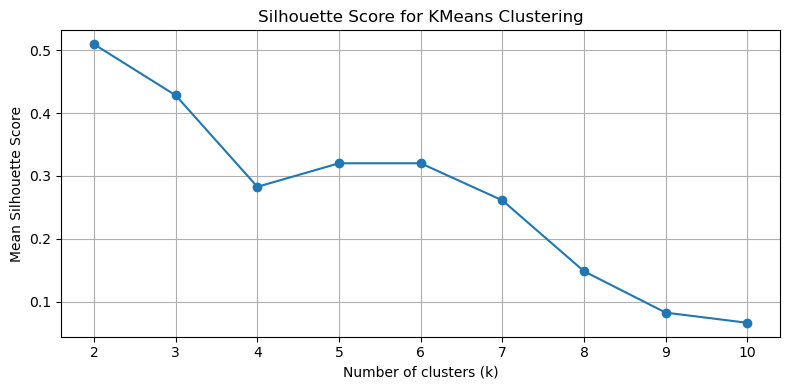

Best number of clusters: 2 (Silhouette = 0.509)


In [120]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(summary_df)

# Search for optimal k
best_k = find_optimal_k(X_scaled, k_range=range(2, 11))


c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

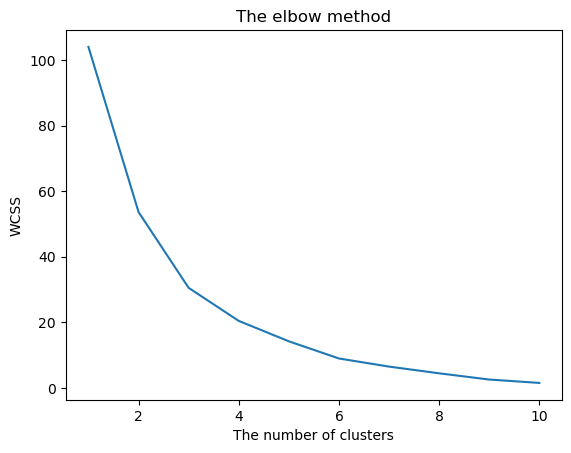

In [132]:
# Using the elbow method to find the optimal number of clusters
wcss = []
for i in range(1,11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)

plt.plot(range(1,11), wcss)
plt.title('The elbow method')
plt.xlabel('The number of clusters')
plt.ylabel('WCSS')
plt.show()

### Find best clustering algorithm

In [130]:
def full_clustering_pipeline(combined_metrics_df, n_clusters=3):
    # Step 1: Summarize metrics per patient
    summary = combined_metrics_df.groupby("patient").agg({
        "shannon_entropy": ["mean", "std"],
        "clonality": ["mean", "std"],
        "inverse_simpson": ["mean"],
        "gini_coefficient": ["mean"],
        "DE50": ["mean"]
    })
    summary.columns = ["_".join(col) for col in summary.columns]  # flatten MultiIndex
    summary = summary.dropna()
    patients = summary.index

    # Step 2: Normalize and reduce dimensionality
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(summary)
    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)

    # Step 3: Apply clustering methods
    clustering_results = {}

    # KMeans clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_labels = kmeans.fit_predict(X_scaled)
    clustering_results["KMeans"] = kmeans_labels

    # Agglomerative clustering
    agglom = AgglomerativeClustering(n_clusters=n_clusters)
    agglom_labels = agglom.fit_predict(X_scaled)
    clustering_results["Agglomerative"] = agglom_labels

    # DBSCAN clustering
    dbscan = DBSCAN(eps=1.0, min_samples=2)
    dbscan_labels = dbscan.fit_predict(X_scaled)
    # spec_clus = SpectralClustering(n_clusters=n_clusters, assign_labels='discretize',random_state=0).fit(X_scaled)
    # labels = spec_clus.fit_predict(X_scaled)
    clustering_results["DBSCAN"] = dbscan_labels


    # Step 4: Evaluate clusters (Silhouette Score)
    eval_scores = {}
    for name, labels in clustering_results.items():
        if len(set(labels)) > 1 and -1 not in labels:
            score = silhouette_score(X_scaled, labels)
        else:
            score = np.nan
        eval_scores[name] = score

    # Step 5: Plot results
    fig, axs = plt.subplots(1, len(clustering_results), figsize=(16, 5))
    for subplot_index, (method, labels) in enumerate(clustering_results.items()):
        ax = axs[subplot_index]
        ax.scatter(components[:, 0], components[:, 1], c=labels, cmap='Set2', s=100)
        ax.set_title(f"{method} (Silhouette: {eval_scores[method]:.2f})")
        ax.set_xlabel("PCA 1")
        ax.set_ylabel("PCA 2")
        ax.grid(True)

        # Proper labeling
        texts = []
        for j, label in enumerate(patients):
            texts.append(ax.text(components[j, 0], components[j, 1], label, fontsize=8))

        adjust_text(texts, ax=ax, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5))

    plt.tight_layout()
    plt.show()

    # Step 6: Return cluster-labeled summary and evaluation scores
    result_df = summary.copy()
    for method, labels in clustering_results.items():
        result_df[f"{method}_cluster"] = labels

    return result_df, eval_scores



c:\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


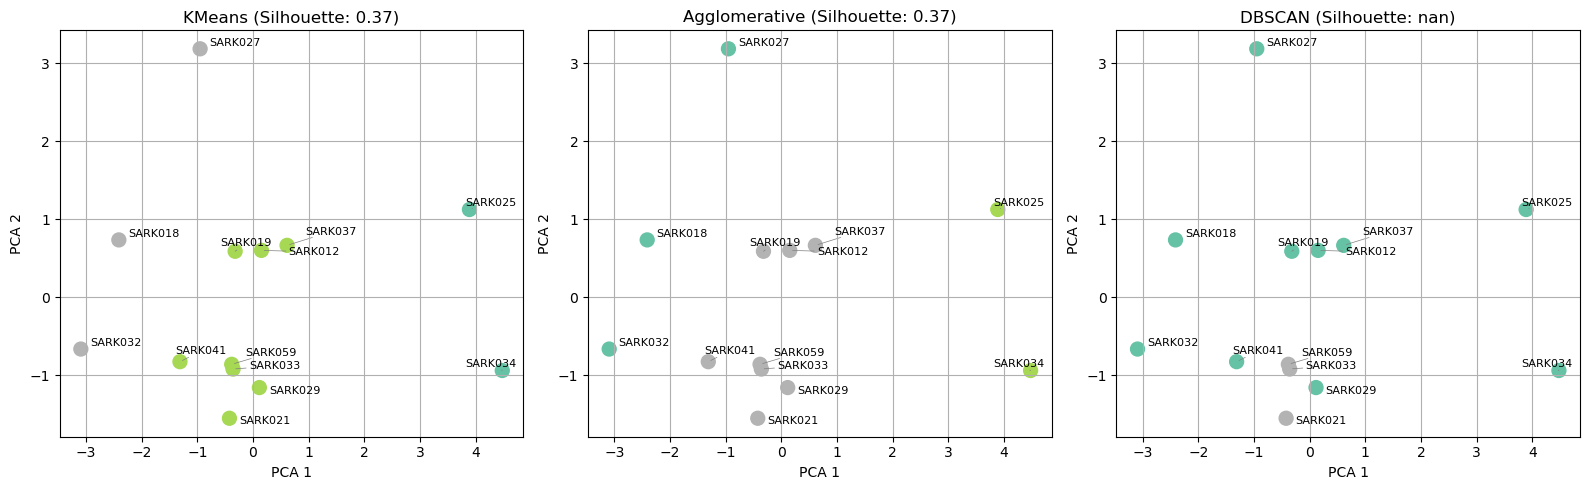

         shannon_entropy_mean  shannon_entropy_std  clonality_mean  \
patient                                                              
SARK012              5.178636             0.433470        0.192697   
SARK018              1.614834             0.301159        0.592068   
SARK019              6.015640             0.429004        0.295680   
SARK021              5.863018             0.104296        0.273584   
SARK025              8.766530             0.840105        0.095109   

         clonality_std  inverse_simpson_mean  gini_coefficient_mean  \
patient                                                               
SARK012       0.064640             19.943468               0.615958   
SARK018       0.082411              1.676280               0.817401   
SARK019       0.072033             19.259071               0.743064   
SARK021       0.015748             23.887076               0.771486   
SARK025       0.041102             85.443861               0.378786   

          D

In [133]:
result_df, eval_scores = full_clustering_pipeline(combined_metrics_df, n_clusters=3)
print(result_df.head())
print("Silhouette scores:", eval_scores)

## Feature pairplot

In [76]:
def plot_seaborn_pairplot(result_df, cluster_col="Agglomerative_cluster"):
    # Select only numeric columns and cluster
    plot_df = result_df.copy()
    plot_df[cluster_col] = plot_df[cluster_col].astype(str)  # for color separation
    numeric_cols = [col for col in plot_df.columns if any(metric in col for metric in 
        ['shannon_entropy', 'clonality', 'inverse_simpson', 'gini_coefficient', 'DE50'])]

    sns.pairplot(
        plot_df[numeric_cols + [cluster_col]], 
        hue=cluster_col, 
        palette='Set2',
        plot_kws={'alpha': 0.8, 's': 60},
        diag_kind='kde'
    )
    plt.suptitle(f"Pairwise Metric Comparison by {cluster_col}", y=1.02)
    plt.show()

In [134]:

def plot_seaborn_pairplot_with_labels(result_df, cluster_col="Agglomerative_cluster"):
    # Prepare dataframe
    df = result_df.copy()
    df[cluster_col] = df[cluster_col].astype(str)
    
    # Choose only the metric columns
    metric_cols = [col for col in df.columns if any(key in col for key in 
                  ['shannon_entropy', 'clonality', 'inverse_simpson', 'gini_coefficient', 'DE50'])]
    
    # Set patient name as a column
    df = df.reset_index()  # in case patient is index
    df.rename(columns={'index': 'patient'}, inplace=True)

    # Create pairplot
    g = sns.pairplot(
        df[metric_cols + ['patient', cluster_col]], 
        hue=cluster_col, 
        palette='Set2',
        plot_kws={'alpha': 0.7, 's': 60},
        diag_kind='kde'
    )

    # Add text labels to each scatterplot
    for i, j in zip(*np.triu_indices_from(g.axes, k=1)):
        ax = g.axes[i, j]
        for k, row in df.iterrows():
            ax.text(row[metric_cols[j]], row[metric_cols[i]], row['patient'], 
                    fontsize=7, alpha=0.7)

    plt.suptitle(f"Pairwise Metric Comparison with Patient Labels ({cluster_col})", y=1.02)
    plt.tight_layout()
    plt.show()


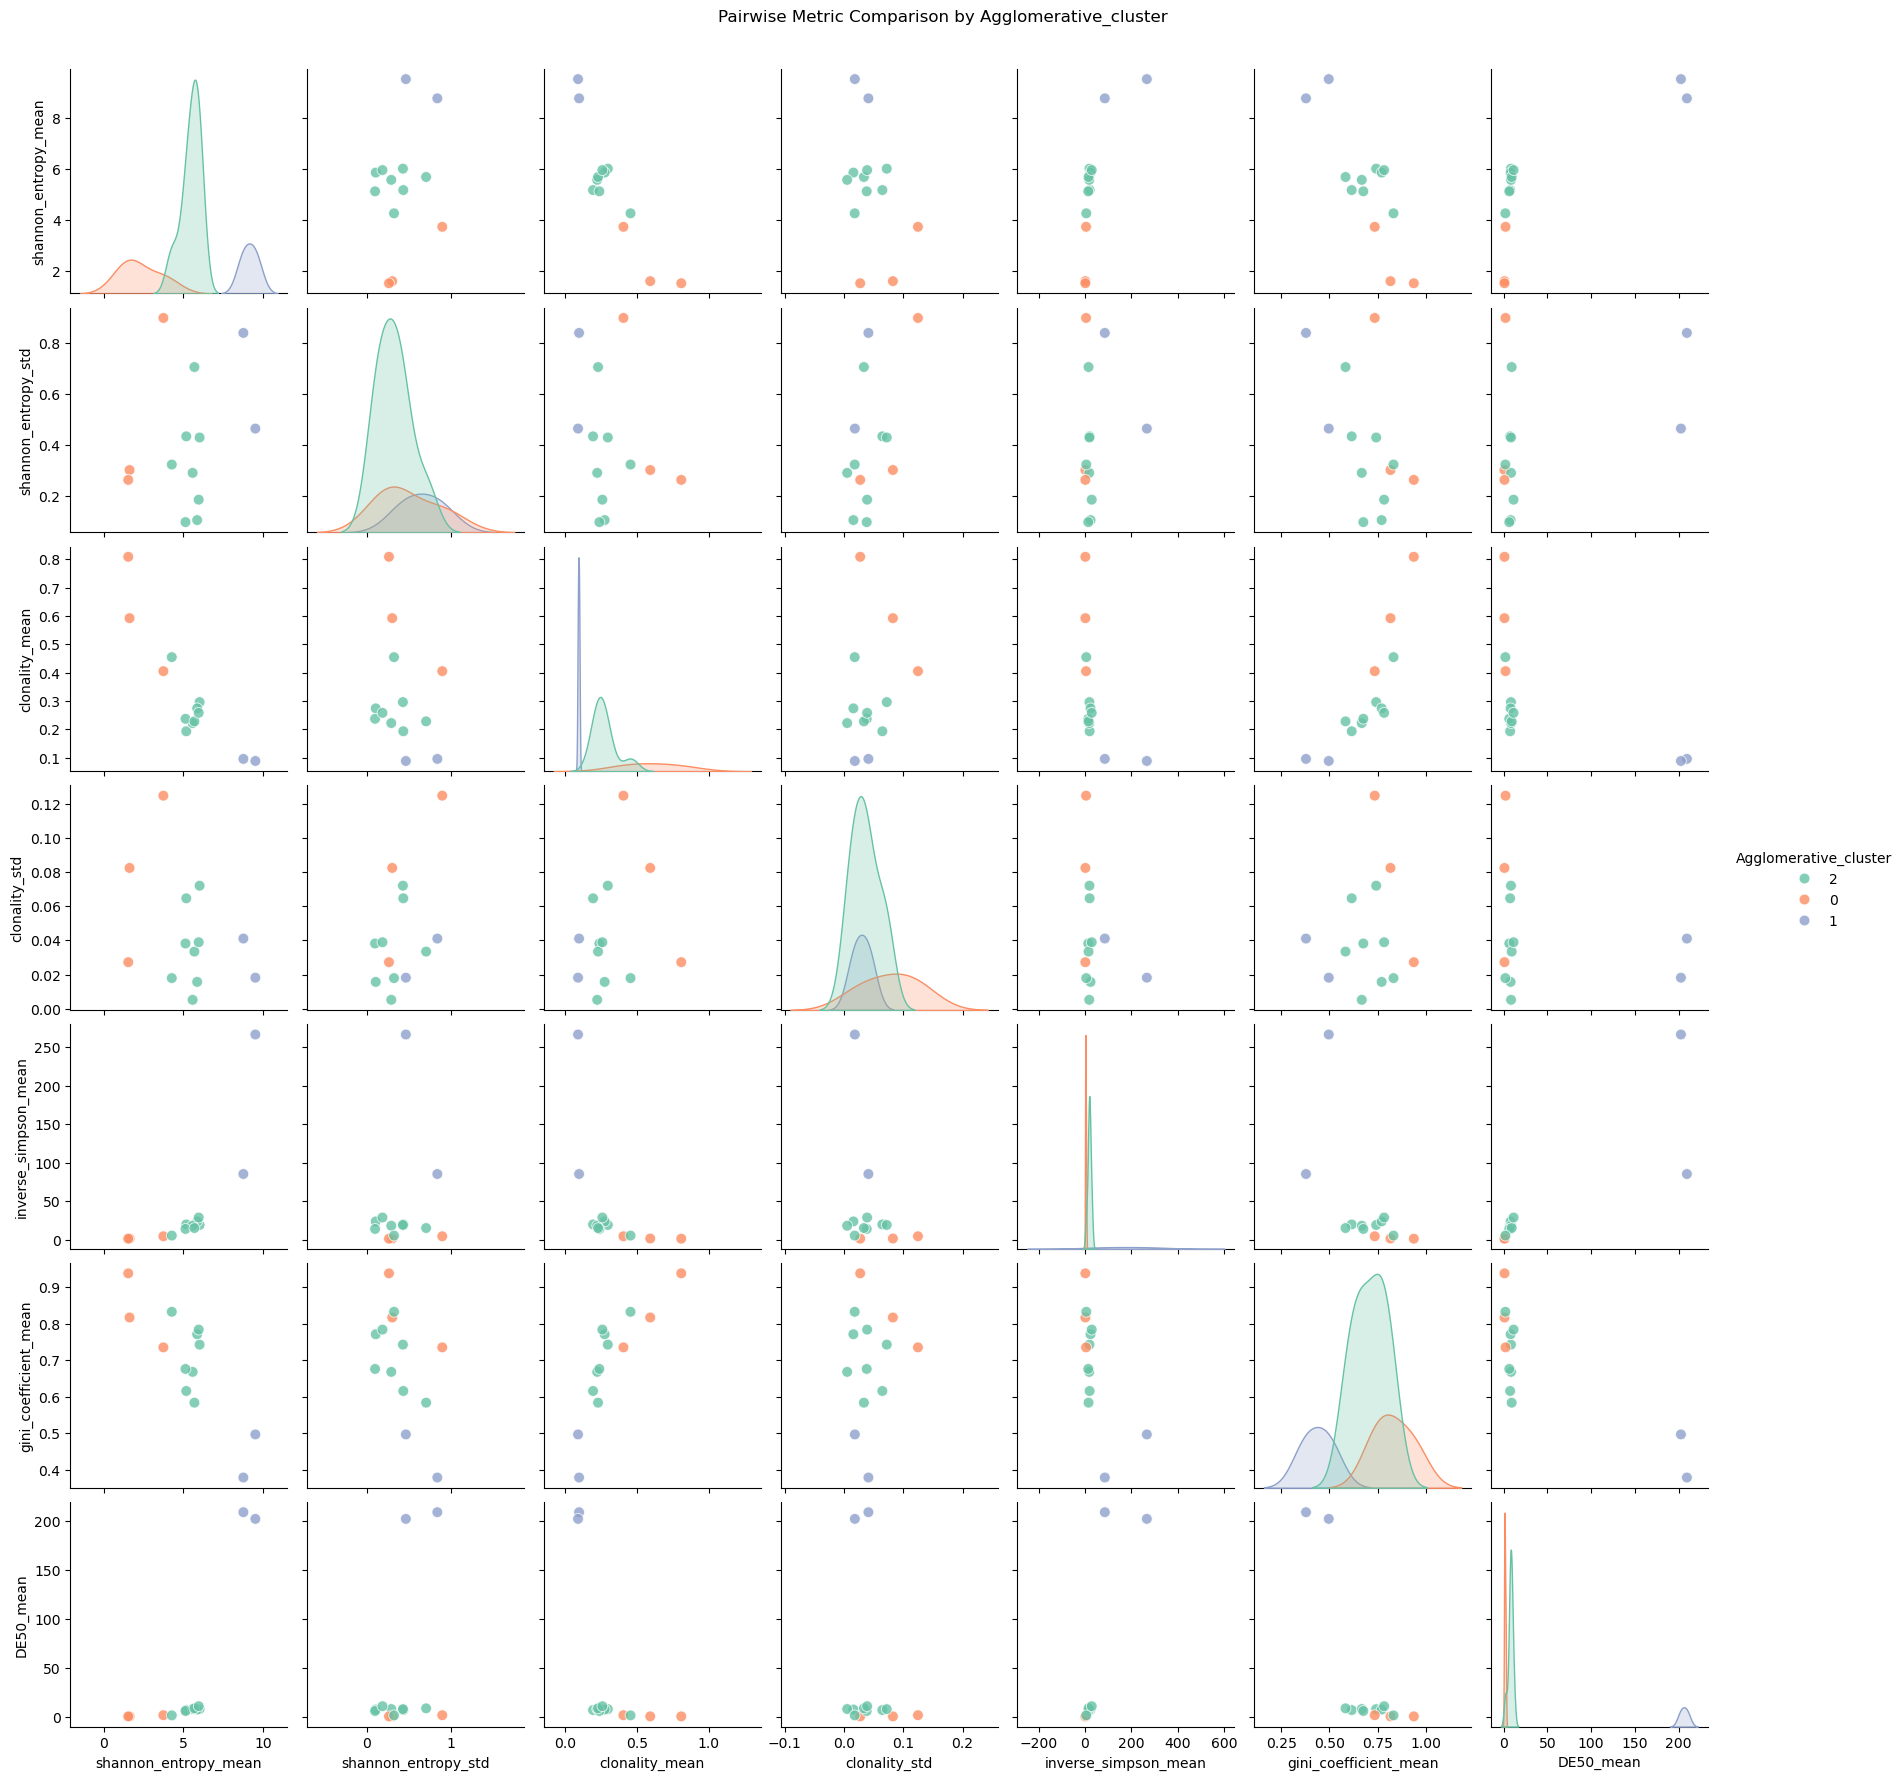

In [135]:
plot_seaborn_pairplot(result_df, cluster_col="Agglomerative_cluster")


In [136]:
def plot_metric_pair_with_labels(df, x='shannon_entropy_mean', y='gini_coefficient_mean', cluster_col='Agglomerative_cluster'):
    df = df.reset_index() if 'patient' not in df.columns else df.copy()
    df[cluster_col] = df[cluster_col].astype(str)

    plt.figure(figsize=(8, 6))
    sns.scatterplot(data=df, x=x, y=y, hue=cluster_col, palette='Set2', s=100)

    for i, row in df.iterrows():
        plt.text(row[x] + 0.05, row[y], row['patient'], fontsize=8, alpha=0.7)

    plt.title(f"{x.replace('_', ' ').title()} vs {y.replace('_', ' ').title()}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


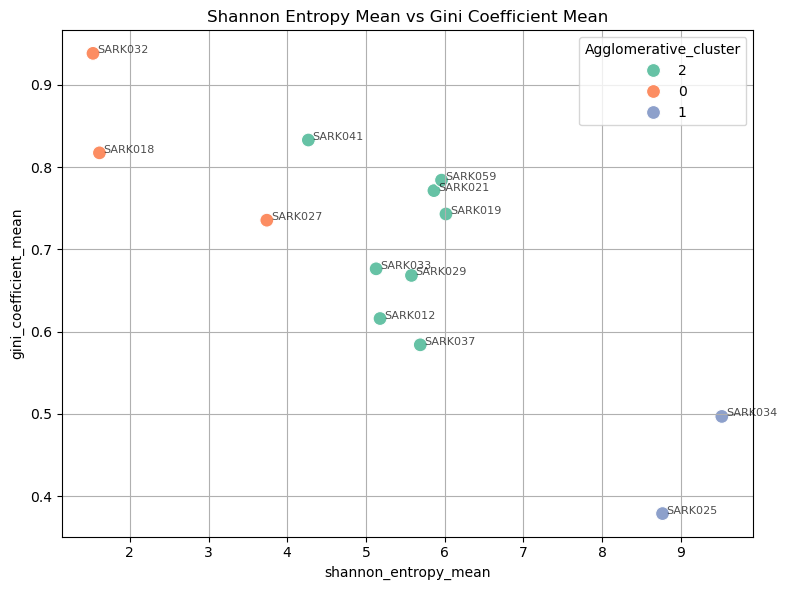

In [137]:
plot_metric_pair_with_labels(result_df, 
    x='shannon_entropy_mean', 
    y='gini_coefficient_mean', 
    cluster_col='Agglomerative_cluster')


## Cluster profile heatmap
It is a useful summary visualization to understand what makes the clusters different.

Helps interpret clustering biologically or clinically. For example:

- One cluster may have high clonality → potential T cell expansion.
- Another may have high richness and entropy → diverse, polyclonal repertoire.

Can be used to label clusters (e.g., "high diversity", "clonal expansion", etc.)

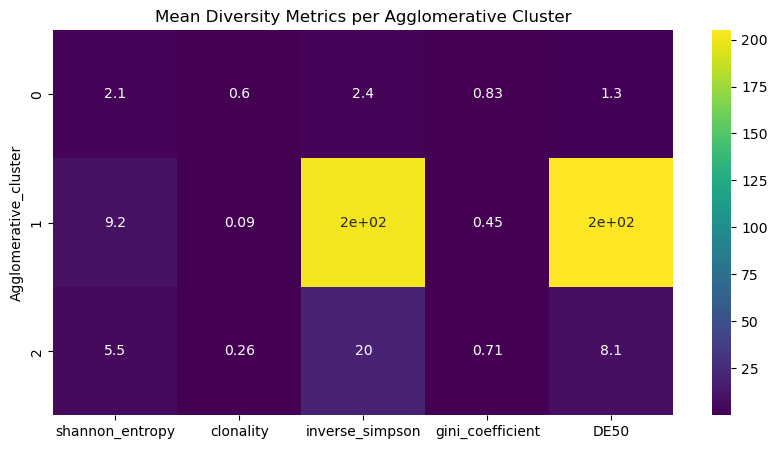

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

# Add cluster label to original metrics
combined_with_clusters = combined_metrics_df.merge(result_df[['Agglomerative_cluster']], on='patient')

# Plot cluster-averaged metric profiles
metrics = ['shannon_entropy', 'clonality', 'inverse_simpson', 'gini_coefficient', 'DE50']
cluster_means = combined_with_clusters.groupby('Agglomerative_cluster')[metrics].mean()

plt.figure(figsize=(10, 5))
sns.heatmap(cluster_means, annot=True, cmap="viridis")
plt.title("Mean Diversity Metrics per Agglomerative Cluster")
plt.show()


In [139]:
from matplotlib.lines import Line2D

def plot_metric_trajectories_by_cluster(combined_metrics_df, result_df, metric='clonality', cluster_col='Agglomerative_cluster'):
    # Merge clustering info
    df = combined_metrics_df.merge(result_df[[cluster_col]], on='patient', how='inner')

    # Plot setup
    plt.figure(figsize=(12, 6))
    unique_clusters = sorted(df[cluster_col].unique())
    palette = sns.color_palette("Set2", len(unique_clusters))

    # Track for custom legend
    cluster_color_map = {}

    for cluster_id, cluster_df in df.groupby(cluster_col):
        cluster_color = palette[cluster_id]
        cluster_color_map[cluster_id] = cluster_color
        for patient_id, patient_df in cluster_df.groupby("patient"):
            patient_df = patient_df.sort_values("time")
            plt.plot(patient_df["time"], patient_df[metric], color=cluster_color, alpha=0.7)
            # Label at the end of the trajectory
            plt.text(patient_df["time"].max() + 1, patient_df[metric].iloc[-1], patient_id, fontsize=8, color=cluster_color)

    # Create custom legend
    legend_elements = [
        Line2D([0], [0], color=color, lw=2, label=f'Cluster {clust}')
        for clust, color in cluster_color_map.items()
    ]
    plt.legend(handles=legend_elements, title="Clusters", loc='best')

    plt.title(f"{metric.replace('_', ' ').title()} Trajectories Colored by Cluster")
    plt.xlabel("Time")
    plt.ylabel(metric.replace('_', ' ').title())
    plt.grid(True)
    plt.tight_layout()
    plt.show()


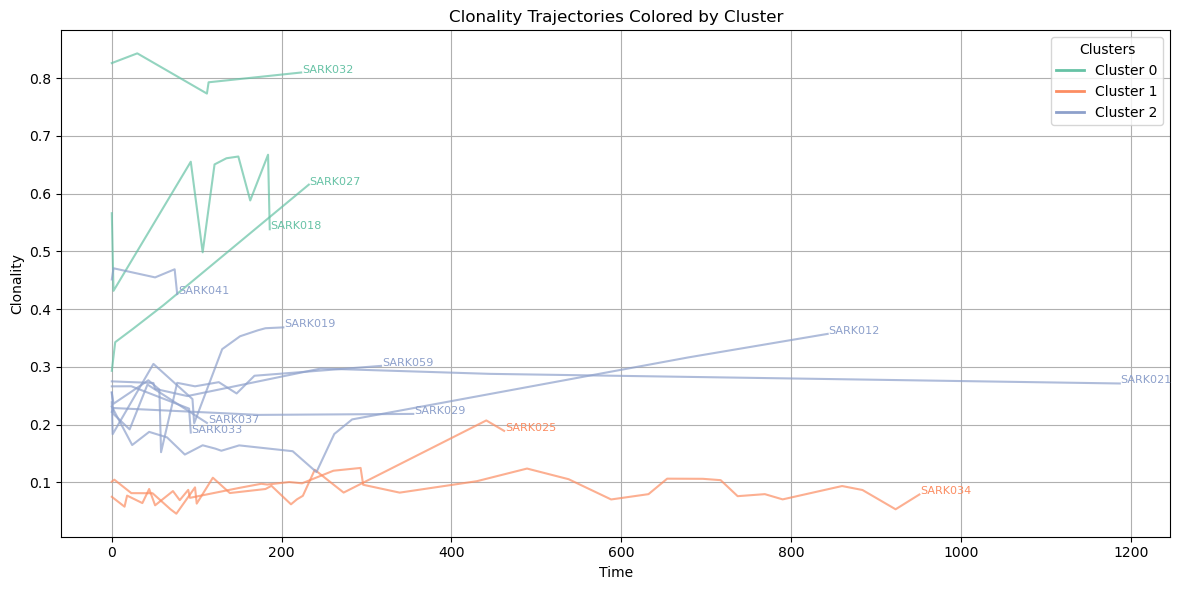

In [140]:
plot_metric_trajectories_by_cluster(combined_metrics_df, result_df, metric='clonality')

# Pair comparison -  No mirado aun, existe para que no se me olvide

In [141]:
import seaborn as sns

def plot_similarity_heatmap(similarity_df, metric='morisita_horn_index', patient_id=None):
    if patient_id:
        df = similarity_df[similarity_df['patient'] == patient_id].copy()
    else:
        print("Please specify a patient to plot.")
        return

    # Build symmetric matrix
    all_times = sorted(set(df['time1']).union(df['time2']))
    sim_matrix = pd.DataFrame(index=all_times, columns=all_times, dtype=float)

    for _, row in df.iterrows():
        t1, t2 = row['time1'], row['time2']
        sim = row[metric]
        sim_matrix.loc[t1, t2] = sim
        sim_matrix.loc[t2, t1] = sim
        sim_matrix.loc[t1, t1] = 1
        sim_matrix.loc[t2, t2] = 1

    sim_matrix = sim_matrix.fillna(1)  # assume perfect self-similarity

    # Plot heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(sim_matrix, annot=True, cmap="YlGnBu", square=True, cbar_kws={"label": metric})
    plt.title(f"{metric.replace('_', ' ').title()} Heatmap – {patient_id}")
    plt.xlabel("Time")
    plt.ylabel("Time")
    plt.tight_layout()
    plt.show()


In [142]:
from sklearn.manifold import MDS
from scipy.spatial.distance import squareform

def plot_similarity_mds(similarity_df, metric='morisita_horn_index', patient_id=None):
    if patient_id:
        df = similarity_df[similarity_df['patient'] == patient_id].copy()
    else:
        print("Please specify a patient.")
        return

    # Build full symmetric distance matrix (1 - similarity)
    all_times = sorted(set(df['time1']).union(df['time2']))
    dist_matrix = pd.DataFrame(index=all_times, columns=all_times, dtype=float)

    for _, row in df.iterrows():
        t1, t2 = row['time1'], row['time2']
        dist = 1 - row[metric]
        dist_matrix.loc[t1, t2] = dist
        dist_matrix.loc[t2, t1] = dist
        dist_matrix.loc[t1, t1] = 0
        dist_matrix.loc[t2, t2] = 0

    dist_matrix = dist_matrix.fillna(0)

    # Apply MDS
    mds = MDS(dissimilarity='precomputed', random_state=42)
    coords = mds.fit_transform(dist_matrix.values)

    # Plot
    plt.figure(figsize=(6, 5))
    plt.scatter(coords[:, 0], coords[:, 1], s=100)
    for i, label in enumerate(dist_matrix.index):
        plt.text(coords[i, 0] + 0.01, coords[i, 1], str(label), fontsize=9)
    plt.title(f"MDS – {metric.replace('_', ' ').title()} – {patient_id}")
    plt.xlabel("MDS1")
    plt.ylabel("MDS2")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [83]:
from scipy.cluster.hierarchy import linkage, dendrogram

def plot_similarity_dendrogram(similarity_df, metric='morisita_horn_index', patient_id=None):
    if patient_id:
        df = similarity_df[similarity_df['patient'] == patient_id].copy()
    else:
        print("Please specify a patient.")
        return

    all_times = sorted(set(df['time1']).union(df['time2']))
    dist_matrix = pd.DataFrame(index=all_times, columns=all_times, dtype=float)

    for _, row in df.iterrows():
        t1, t2 = row['time1'], row['time2']
        dist = 1 - row[metric]
        dist_matrix.loc[t1, t2] = dist
        dist_matrix.loc[t2, t1] = dist
        dist_matrix.loc[t1, t1] = 0
        dist_matrix.loc[t2, t2] = 0

    dist_matrix = dist_matrix.fillna(0)
    condensed = squareform(dist_matrix.values)

    linkage_matrix = linkage(condensed, method='average')

    plt.figure(figsize=(8, 4))
    dendrogram(linkage_matrix, labels=dist_matrix.index, leaf_rotation=90)
    plt.title(f"Dendrogram – {metric.replace('_', ' ').title()} – {patient_id}")
    plt.tight_layout()
    plt.show()


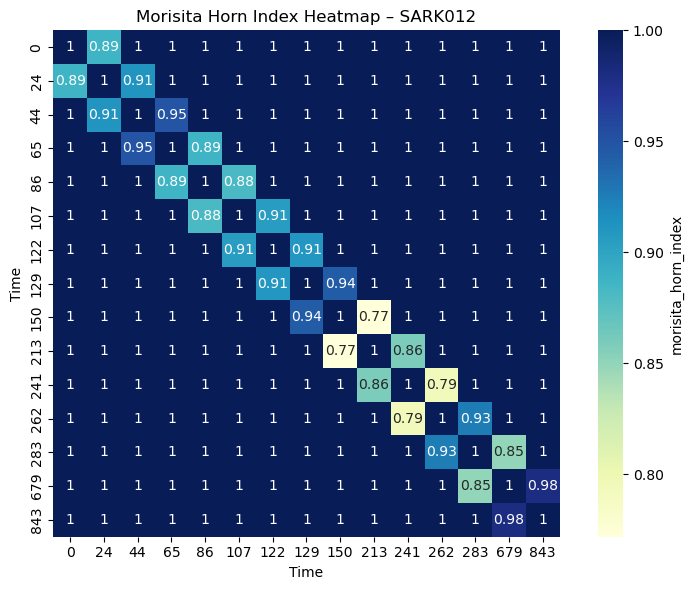

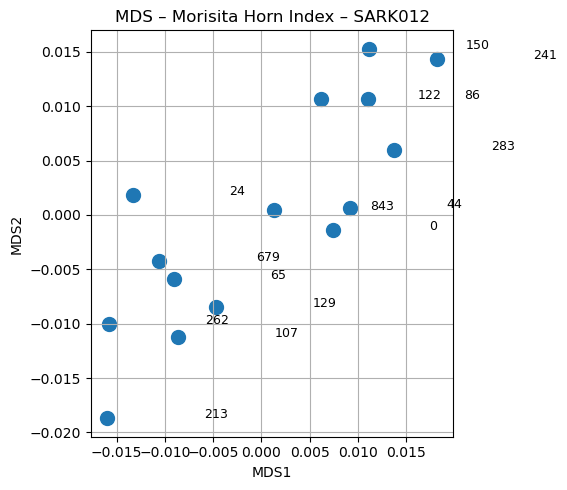

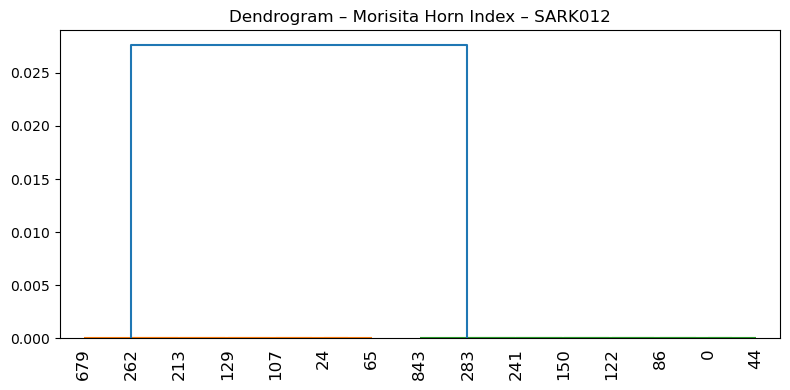

In [84]:
plot_similarity_heatmap(all_similarities_df, metric='morisita_horn_index', patient_id='SARK012')
plot_similarity_mds(all_similarities_df, metric='morisita_horn_index', patient_id='SARK012')
plot_similarity_dendrogram(all_similarities_df, metric='morisita_horn_index', patient_id='SARK012')
